In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import joblib


In [ ]:
df = pd.read_csv('Telco-Customer-Churn.csv')
print(df.head())
print(df.shape)

In [ ]:
print(df.info())
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') #convert total charges to numeric

In [ ]:
print("\nmissing values in per column:") # checking for null values
print(df.isnull().sum())

In [5]:
df.dropna(inplace=True)

In [6]:
df.drop(['customerID'], axis=1, inplace=True)

In [9]:
print("Churn Count:")
print(df['Churn'].value_counts())

Churn Count:
Churn
No     5163
Yes    1869
Name: count, dtype: int64


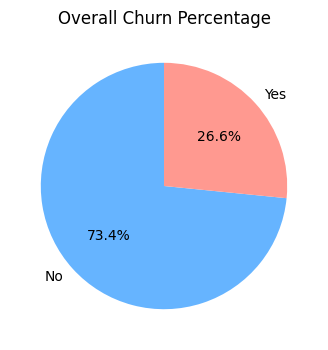

In [ ]:
plt.figure(figsize=(6, 4))
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b4ff','#ff9990'], startangle=90)
plt.title('Overall Churn Percentage')
plt.ylabel('') # Hides the 'Churn' ylabel on the side
plt.xlabel('') # Hides the 'Churn' xlabel on the side
plt.show()



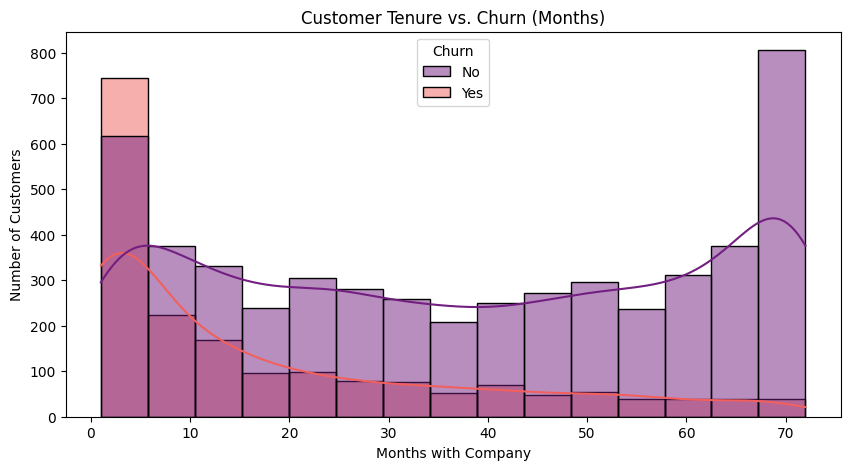

In [52]:
# 2. Tenure vs Churn (The "Loyalty" Insight)
# Does how long they've been with us matter?
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, palette='magma')
plt.title('Customer Tenure vs. Churn (Months)')
plt.xlabel('Months with Company')
plt.ylabel('Number of Customers')
plt.show()


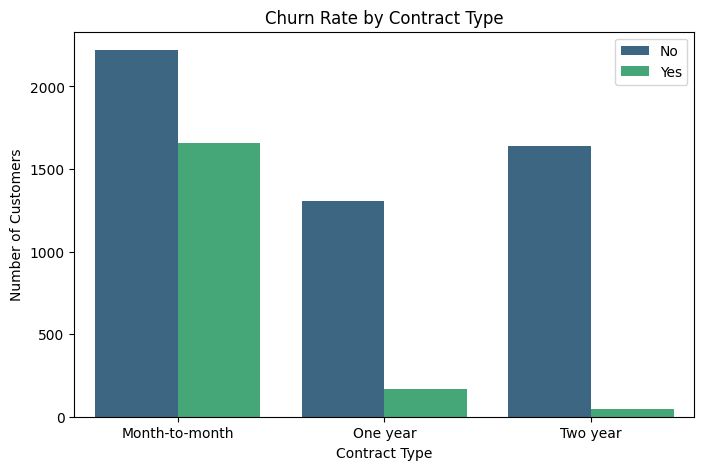

In [48]:
# Contract Type vs Churn (The "Business Strategy" Insight)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Contract', hue='Churn', palette='viridis')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()

In [58]:
# Define Features (X) and Target (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convert 'Yes'/'No' to 1/0

In [63]:
# Identify which columns are text (categorical) and which are column numeric
categorical_cols = X.select_dtypes(include=['object']).columns.to_list()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.to_list()

print(f'Categorical columns to encoded: {list(categorical_cols)}')
print(f'Numeric columns to scaled: {list(numeric_cols)}')

Categorical columns to encoded: []
Numeric columns to scaled: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
# Applying One-Hot Encoding
# I use pd.get_dummies on the whole X dataframe
# drop_first=True helps prevent mathematical errors in the model
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Encoding successful")
print(f"New total number of columns: {X.shape}")
print(X.head())

In [66]:
# Spliting the data into Training and Testing sets
# I use 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the numeric features
scaler = StandardScaler()
# We only scale the numeric columns we identified earlier
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Data is now ready for training!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Data is now ready for training!
Training samples: 5625
Testing samples: 1407


In [76]:
# Initializing the models
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# 2. Train the models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# 3. Predictions
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

# 4. Results
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, gb_preds):.4f}")

Random Forest Accuracy: 0.7875
XGBoost Accuracy: 0.7633
Gradient Boosting Accuracy: 0.7896


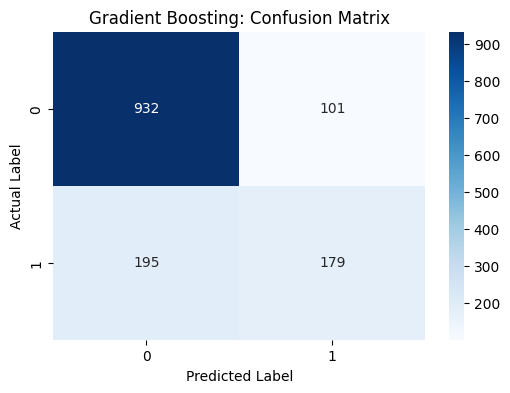

Gradient Boosting Detailed Report ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [77]:
# Generating Confusion Matrix
cm = confusion_matrix(y_test, gb_preds)

# Plotting the Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Print the Detailed Classification Report
print("Gradient Boosting Detailed Report ---")
print(classification_report(y_test, gb_preds))

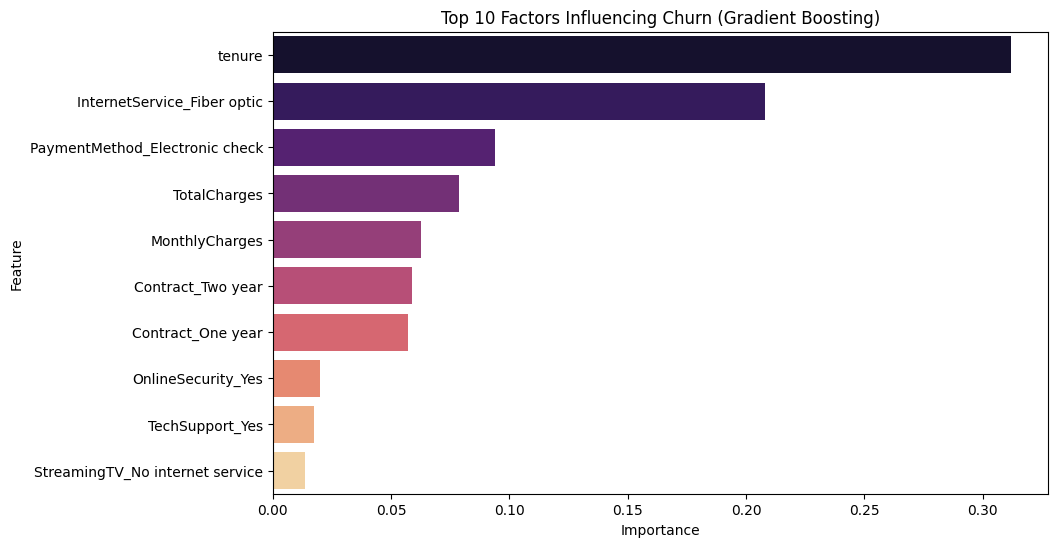

In [ ]:
# Get feature importances from the Gradient Boosting model
importances = gb_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and show top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=top_10_features, palette='magma', legend=False)
plt.title('Top 10 Factors Influencing Churn (Gradient Boosting)')
plt.show()

In [79]:
# Replace 'gb_model' with 'rf_model' if Random Forest was actually higher
final_model = gb_model 

# 1. Save the Model
joblib.dump(final_model, 'churn_model.pkl')

# 2. Save the Scaler (Crucial for the app to work!)
joblib.dump(scaler, 'scaler.pkl')

# 3. Save the Feature Names (So the app knows the order of columns)
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("Files saved successfully! Ready for Streamlit.")

Files saved successfully! Ready for Streamlit.
